In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import time
from DUT import DUT
import matplotlib.pyplot as plt
import numpy as np
import json
import sys

import pandas as pd

from tqdm import tqdm

In [3]:
my_dut = DUT(20, True, 3.2)

In [4]:
print("Defected Measures:", my_dut.defected_meas) 
print("Negative Correlation:", my_dut.neg_corr)

Defected Measures: [40  2]
Negative Correlation: [(40, 37), (2, 29)]


In [5]:
n_train = 2500
n_test = 20000 - n_train * 2

In [6]:
meastime, nmeas, nport, meas, ports, expyield = my_dut.info()
print("DUT: meas. time= ", meastime, " | measurements= ", nmeas, " | ports= ", nport, " | expected yield = ", expyield)

DUT: meas. time=  128.43814099999997  | measurements=  45  | ports=  12  | expected yield =  3.2


In [7]:
error_count = 0
X = []
Y = []
t=0

data= {}
data['component']=[]

In [8]:
fails = []
my_err = 0

In [9]:
for x in range(n_train):    
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]
    
    if x % 500 == 0:
        my_dut.calibrate()
        
    toggle = True

    for i in range(0, nmeas):
        t, result, dist = my_dut.gen_meas_idx(i)
        
        if dist > 1: fails.append(i)
        
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
                
        if result == False and toggle:
            toggle = False
            my_err += 1
            break

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  0.1  took  532.1566359999999  seconds.
Calibration at  61151.27853100077  took  532.1566359999999  seconds.
Calibration at  122614.4770180065  took  532.1566359999999  seconds.
Calibration at  184496.5206400161  took  532.1566359999999  seconds.
Calibration at  245693.0115680265  took  532.1566359999999  seconds.


In [10]:
a, c = np.unique(fails, return_counts=True)
indexes = np.zeros(nmeas)
indexes[a] = c
sorted_meas = np.argsort(-indexes)

sorted_meas #= sorted_meas # [:-sum(indexes < 1)]

array([ 2, 29, 37, 40,  3,  4, 11,  6, 18,  7, 36, 14, 23, 26, 34, 10,  9,
       35, 42, 19, 20, 39, 30,  0, 41, 28, 38, 22, 25,  1, 12, 15, 17, 21,
       16, 24, 44, 27, 13,  8, 33, 32, 31, 43,  5])

In [11]:
import itertools

all_possible_tuples = {
    (i, j): 0 for i, j in itertools.product(range(nmeas), range(nmeas)) if i != j and list(sorted_meas).index(i) < list(sorted_meas).index(j) 
}

In [12]:
len(all_possible_tuples)

990

In [13]:
for x in range(n_train):    
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]
    
    if x % 500 == 0:
        my_dut.calibrate()
    
    failed = np.zeros(nmeas)

    for i in sorted_meas:
        t, result, dist = my_dut.gen_meas_idx(i)
        
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
                
        if result == False:
            failed[i] = 1
            my_err += 1
            break

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res
    
    for i, j in all_possible_tuples.keys():
        if failed[i] == 0 and failed[j] == 1:
            all_possible_tuples[(i, j)] += 1

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  307608.49596999836  took  532.1566359999999  seconds.
Calibration at  366816.16888595745  took  532.1566359999999  seconds.
Calibration at  426860.1047999164  took  532.1566359999999  seconds.
Calibration at  486130.28423687565  took  532.1566359999999  seconds.
Calibration at  545776.5726378447  took  532.1566359999999  seconds.


In [14]:
sorted_meas = []

In [15]:
for i, j in sorted(all_possible_tuples, key=all_possible_tuples.get, reverse=True):
    if i not in sorted_meas: sorted_meas.append(i)
    if j not in sorted_meas: sorted_meas.append(j)

In [16]:
for x in range(n_test):
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]

    if x % 500 == 0:
        my_dut.calibrate()
    
    incount = True
    for j, i in enumerate(sorted_meas):
        t, result, dist = my_dut.gen_meas_idx(i, incount)
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
        
        if result == False or j > nmeas - sum(indexes < 1):
            if result == False and incount:
                my_err +=1
            incount = False

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  606021.1914438315  took  532.1566359999999  seconds.
Calibration at  665114.4763568445  took  532.1566359999999  seconds.
Calibration at  721959.2610528567  took  532.1566359999999  seconds.
Calibration at  779011.9039218685  took  532.1566359999999  seconds.
Calibration at  837400.9296338814  took  532.1566359999999  seconds.
Calibration at  894993.0864588937  took  532.1566359999999  seconds.
Calibration at  952947.8435459064  took  532.1566359999999  seconds.
Calibration at  1012255.1468729196  took  532.1566359999999  seconds.
Calibration at  1070158.5468560138  took  532.1566359999999  seconds.
Calibration at  1128925.8869452474  took  532.1566359999999  seconds.
Calibration at  1186489.8095504765  took  532.1566359999999  seconds.
Calibration at  1245488.2387127108  took  532.1566359999999  seconds.
Calibration at  1303306.939558942  took  532.1566359999999  seconds.
Calibration at  1361127.6475211706  took  532.1566359999999  seconds.
Calibration at  1419341.3975

Total:  2354374.2569387318 s  15000  (  2011  |  1892  |  2011  ) ==>  0.8659333333333333
2003


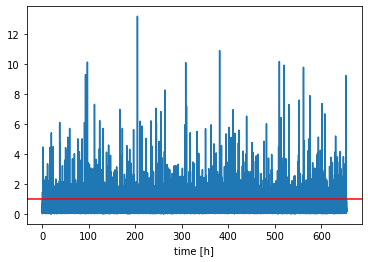

In [17]:
error_dut, error_meas = my_dut.get_errordutcount()
print("Total: ",t, "s ", x+1, " ( ", error_count, " | ", error_dut, " | ", error_meas, " ) ==> ", (x+1-error_count)/(x+1) )
print(my_err)
# write json log
# outfile = open('result.json', 'w')
# json.dump(data, outfile, indent=2)

# plot results
timeAxis = [x / 3600. for x in X]
plt.xlabel('time [h]')
plt.plot(timeAxis,Y)
plt.axhline(y=1., xmin=0, xmax=1, color='r')
plt.show()